#### Code to train classification models
**TODO**:
- Missing values ?
- Categorical features
- Use it to filter out obvious non-matches
- geopy for missing address

- better retrieval of TPs using lgbm model
- https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html
- catboost, lgbm
- Voting & thresh tuning ? https://www.kaggle.com/code/nlztrk/public-0-861-pykakasi-radian-coordinates/notebook
- Fts & nan from https://www.kaggle.com/code/theoviel/4sq-tar-k-training

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src

/home/theo/kaggle/foursquare/src


## Imports

In [3]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = "0"

import torch
torch.cuda.get_device_name(0)

'NVIDIA RTX A6000'

In [4]:
import os
import gc
import re
import glob
import json
import cudf
import lofo
import torch
import pickle
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from collections import Counter
from pandarallel import pandarallel
from numerize.numerize import numerize
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GroupKFold
from cuml.feature_extraction.text import TfidfVectorizer

pandarallel.initialize(progress_bar=False, use_memory_fs=False)
pd.options.display.max_columns = 500

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [5]:
from params import *

from data.features import *
from data.preparation import *
from data.post_processing import *

from utils.logger import prepare_log_folder, create_logger, save_config
from utils.metrics import *

from model_zoo.xgb import train_xgb, objective_xgb, lofo_xgb
from model_zoo.catboost import train_catboost, objective_catboost, lofo_catboost
from training.main_boosting import k_fold
from utils.plot import *

### Params

In [6]:
EXP_FOLDER = LOG_PATH + "2022-05-19/4/"  # 1 ep, d=256, large
N_NEIGHBORS = 20

EXP_FOLDER_2 = None 
THRESHOLD = None

# EXP_FOLDER_2 = LOG_PATH + "lvl_2/" + "2022-05-25/6/"  # 50 Neighbors
# THRESHOLD = 0.01

# EXP_FOLDER_2 = LOG_PATH + "lvl_2/" + "2022-05-30/1/"  # 20 Neighbors
# THRESHOLD = 0.01  # 0.001

# EXP_FOLDER_2 = LOG_PATH + "lvl_2/" + "2022-06-06/3/"  # 20 Neighbors
# THRESHOLD = 0.01  # 0.001

FOLD = 0

PRECOMPUTED = True

# MAX_DIST_POS = 0.015
# MAX_DIST_NN = 0.3

MAX_DIST_POS = None  # 0.02
MAX_DIST_NN = None  # 0.35

CONVERT_JAP = True

In [7]:
if PRECOMPUTED:
    if EXP_FOLDER_2 is None:  # lvl 2
        assert os.path.exists(EXP_FOLDER + f'df_p_{N_NEIGHBORS}.csv'), "Level 1 precomputed pairs not found"
    else:  # lvl 3
        assert os.path.exists(EXP_FOLDER_2 + f'df_p_{THRESHOLD}.csv'), "Level 2 precomputed pairs not found"

## Data

In [8]:
gt_matches = json.load(open(DATA_PATH + "gt.json", 'r'))

In [9]:
if not PRECOMPUTED:
    df = pd.read_csv(DATA_PATH + "df_train.csv").set_index('id')
    
    if CONVERT_JAP:
        df = convert_japanese_alphabet(df)

    folds = pd.read_csv(DATA_PATH + "folds_2.csv")[['id', 'fold']]
    df = df.merge(folds, how="left", on="id").set_index("id")

    df = df[df['fold'] == FOLD]
    df['idx'] = np.array(range(len(df)))

    try:
        df = cudf.from_pandas(df)
    except:
        pass
    
    if THRESHOLD is None or EXP_FOLDER_2 is None:  # lvl 2
        df_p = cudf.read_csv(EXP_FOLDER + f'df_pairs_{N_NEIGHBORS}.csv')
    else:  # lvl 3
        df_p = cudf.read_csv(EXP_FOLDER_2 + f'kept_pairs_{THRESHOLD}.csv')

    df_p = df_p.merge(df, how="left", left_on="id_1", right_on="id")
    df_p = df_p.merge(df, how="left", left_on="id_2", right_on="id", suffixes=("_1", "_2"))

    print(f'Retrieved {numerize(len(df_p))} pairs')

## Features
- Add features based on model preds
- Categories clusters using pois (leaky ?)

### Init

In [10]:
NAN_COLS = ['address', 'city', 'state', 'zip', 'url', 'phone']

TF_IDF_COLS = ['name', 'categories', 'address', 'url']

TF_IDF_PARAMS = [
    ((1, 1), 'word'),  # word unigrams
    ((3, 3), 'char_wb'),  # char trigrams
]

STRING_DIST_COLS = ['name', "categories", 'address', 'url', 'phone']

FEATURES_SAME = [
    ('country', is_equal),
    ('state', is_equal),
    ('zip', is_included),
    ('phone', is_included),
    ('city', is_included),
    ('categories', is_included),
]

FEATURES = []

In [11]:
NN_FT_FOLDERS = [
    ("xlm-large", LOG_PATH + "2022-05-19/4/"),            # 1 ep, d=256, large
#     ("roberta", LOG_PATH + "2022-05-20/1/"),              # roberta-large
#     ("xlm-base+url", LOG_PATH + "2022-05-20/2/"),         # base + url
    ("xlm-large+noaddress", LOG_PATH + "2022-05-20/3/"),  # large + no address
]

In [12]:
FT_GROUPS = [
    "nn_dist_l1_*",
    "nn_dist_l2_*",
    "nn_cosine_sim_*",
#     ".*_tf_idf_11_word_sim",
#     ".*_tf_idf_33_char_wb_sim",
#     ".*_lcs$",
#     ".*_gesh", 
#     ".*_jaro",
]

In [13]:
# from utils.logger import upload_to_kaggle

# upload_to_kaggle([f[0] for f in NN_FT_FOLDERS], LOG_PATH + "lvl_1/dataset_1", "Foursquare Weights 1")

### Rank features

In [14]:
if not PRECOMPUTED:
    df_p.loc[df_p['rank'] == -1, 'rank'] = np.nan
    df_p.loc[df_p['rank_nn'] == -1, 'rank_nn'] = np.nan

    df_p['rank_nan'] = df_p["rank"].isna().astype(np.uint8)
    df_p['rank_nn_nan'] = df_p["rank_nn"].isna().astype(np.uint8)
    df_p["rank_both_nan"] = df_p[["rank_nan", "rank_nn_nan"]].min(axis=1)
    df_p["rank_any_nan"] = df_p[["rank_nan", "rank_nn_nan"]].max(axis=1)

#     df_p["rank_min"] = df_p[["rank_nn", "rank"]].min(axis=1)
#     df_p["rank_max"] = - (- df_p[["rank_nn", "rank"]]).max(axis=1)
#     df_p["rank_diff"] = df_p["rank_nn"] - df_p["rank"]

    FEATURES += [
        "rank", "rank_nn", 
        "rank_nan", "rank_nn_nan", 
        "rank_both_nan", "rank_any_nan",
#         "rank_min", "rank_max", 
#         "rank_diff"
    ]

### Nan Features

In [15]:
if not PRECOMPUTED:
    FEATURES += compute_nan_features(df_p, NAN_COLS)

### NN Features

In [16]:
if not PRECOMPUTED:
    for name, folder in tqdm(NN_FT_FOLDERS):
        print(f'-> Adding features using model {name}')
        nn_preds = np.load(folder + f"fts_val_{FOLD}.npy").astype(np.float16)
        nn_preds = torch.from_numpy(nn_preds).cuda()

        FEATURES += compute_nn_distances(df_p, nn_preds, suffix="_" + name)
        
        del nn_preds
        gc.collect()
        torch.cuda.empty_cache()

### Position features

In [17]:
if not PRECOMPUTED:
    FEATURES += compute_position_distances(df_p)

### Filter by distance

In [18]:
def filter_by_distance(row, min_dist_pos=1, min_dist_nn=0.5):
    to_keep = 1

    if row['rank'] >= 1000 and row['rank_nn'] < 1000:
        # Only NN found
        if row['nn_dist_l2'] > min_dist_nn:
            to_keep = 0
    
    elif row['rank'] < 1000 and row['rank_nn'] >= 1000:
        if row['angular_distance_min'] > min_dist_pos:
            to_keep = 0

    return to_keep

In [19]:
if not PRECOMPUTED and MAX_DIST_POS is not None and MAX_DIST_NN is not None:
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)
    sns.boxplot(y="angular_distance_min", x="match", data=df_p[df_p["rank"] < 1000].sample(100000).to_pandas())
    plt.axhline(MAX_DIST_POS, c="salmon")
    plt.yscale('log')
    plt.subplot(1, 2, 2)
    sns.boxplot(y="nn_dist_l2", x="match", data=df_p[df_p["rank_nn"] < 1000].sample(100000).to_pandas())
    plt.axhline(MAX_DIST_NN, c="salmon")
    plt.show()

In [20]:
if not PRECOMPUTED and MAX_DIST_POS is not None and MAX_DIST_NN is not None:
    to_keep = ~(
        (df_p['rank'].isna() & ~df_p['rank_nn'].isna() & (df_p['nn_dist_l2'] > MAX_DIST_NN)) |
        (~df_p['rank'].isna() & df_p['rank_nn'].isna() & (df_p['angular_distance_min'] > MAX_DIST_POS))
    )

    plot_confusion_matrix(to_keep.to_numpy(), df_p['match'].to_numpy(), display_labels=["0", "1"])
    
    ids = get_ids(DATA_PATH, fold=FOLD)
    preds, scores = preds_to_matches(df_p['match'], df_p, threshold=0.5, ids=ids)
    s = compute_iou(preds, gt_matches)
    print(f"Before : Best reachable IoU : {s:.3f} with {numerize(len(df_p))} candidates")
    
    df_p = df_p[to_keep].reset_index(drop=True)

    ids = get_ids(DATA_PATH, fold=FOLD)
    preds, scores = preds_to_matches(df_p['match'], df_p, threshold=0.5, ids=ids)
    s = compute_iou(preds, gt_matches)
    print(f"After  : Best reachable IoU : {s:.3f} with {numerize(len(df_p))} candidates")

### Tf-idf

In [21]:
if not PRECOMPUTED:
    for col in TF_IDF_COLS:
        for ngram_range, analyzer in TF_IDF_PARAMS:
            print(f'Computing feature "{col}_tf_idf_{ngram_range[0]}{ngram_range[1]}_{analyzer}_sim"')

            tf_idf = TfidfVectorizer(use_idf=False, ngram_range=ngram_range, analyzer=analyzer)
            tf_idf_mat = tf_idf.fit_transform(df[col].fillna('nan'))

            df_p[f"{col}_tf_idf_{ngram_range[0]}{ngram_range[1]}_{analyzer}_sim"] = tf_idf_similarity(df_p, tf_idf_mat)
            FEATURES.append(f"{col}_tf_idf_{ngram_range[0]}{ngram_range[1]}_{analyzer}_sim")
        
            # TODO : If one string is nan, put ft to nan ?

### Inclusion / equality features

In [22]:
if not PRECOMPUTED and not isinstance(df_p, pd.DataFrame):
    df_p = df_p.to_pandas()
#     df_p = reduce_mem_usage(df_p)

In [23]:
if not PRECOMPUTED:
    for col, fct in FEATURES_SAME:
        print(f'Computing feature same_{col}')
        df_p[f"same_{col}"] = df_p[[f"{col}_1", f"{col}_2"]].fillna('').parallel_apply(
            lambda x: fct(x[0], x[1]), axis=1
        ).astype(float)

        FEATURES.append(f"same_{col}")

### String dists

In [24]:
if not PRECOMPUTED:
    FEATURES += compute_string_distances(df_p, STRING_DIST_COLS, verbose=1)

### Load / remove useless stuff

In [25]:
TO_KEEP = ['id_1', 'id_2', 'point_of_interest_1', 'point_of_interest_2', 'match'] + FEATURES

if not PRECOMPUTED:
    df_p.drop([c for c in df_p.columns if c not in TO_KEEP], axis=1, inplace=True)
    # df_p.to_csv(EXP_FOLDER + f'df_p_{N_NEIGHBORS}.csv', index=False)
else:
    if EXP_FOLDER_2 is None:  # lvl 2
        df_p = cudf.read_csv(EXP_FOLDER + f'df_p_{N_NEIGHBORS}.csv')
        print('Retrieved precomputed level 1 features')
    else:  # lvl 3
        df_p = cudf.read_csv(EXP_FOLDER_2 + f'df_p_{THRESHOLD}.csv')
        print('Retrieved precomputed level 2 features')
        
    FEATURES = [col for col in df_p.columns[3:] if "fold" not in col and "point_of_interest" not in col]

df_p['match'] = df_p['match'].astype(int)

Retrieved precomputed level 1 features


## Folds / Save computations

TODO : non-leaky splits by considering pairs: 
- gkf on poi, val set considers left and right pois -> (x1, x2) if x1 is in fold 1 val, x2 can be seen during training but not with any element of same poi as x1. This should not be leaky ?
- split before looking for pairs ? No bc it's important to have a 600k set to look for pairs in.

In [26]:
N_SPLITS = 5

if "fold_1" not in df_p.columns:
    if not os.path.exists(DATA_PATH + f"folds_{FOLD}_{N_SPLITS}.csv"):
        gkf = GroupKFold(n_splits=N_SPLITS)
        splits = gkf.split(df, groups=df['point_of_interest'])

        df_split = df.reset_index()[['id', 'point_of_interest']]
        df_split['fold'] = -1

        for i, (_, val_idx) in enumerate(splits):
            df_split.loc[val_idx, 'fold'] = i

        df_split.to_csv(DATA_PATH + f"folds_{FOLD}_{N_SPLITS}.csv", index=False)
        
    df_split = pd.read_csv(DATA_PATH + f"folds_{FOLD}_{N_SPLITS}.csv")

#     df_split = cudf.read_csv(DATA_PATH + f"folds_{FOLD}_{N_SPLITS}.csv")  
#     try:
#         df_p = cudf.from_pandas(df_p)
#     except TypeError:
#         print('df_p already in pandas')

    df_p = df_p.merge(df_split[['id', 'fold']], how="left", left_on="id_1", right_on="id")
    df_p.drop('id', axis=1, inplace=True)
    df_p = df_p.merge(df_split[['id', 'fold']], how="left", left_on="id_2", right_on="id", suffixes=("_1", "_2"))
    df_p.drop('id', axis=1, inplace=True)
    df_p.drop([c for c in df_p.columns if c not in TO_KEEP + ['fold_1', 'fold_2']], axis=1, inplace=True)

    # Save
    if EXP_FOLDER_2 is None:
        save_path = EXP_FOLDER + f'df_p_{N_NEIGHBORS}.csv'
    else:
        save_path = EXP_FOLDER_2 + f'df_p_{THRESHOLD}.csv'

    if isinstance(df_p, pd.DataFrame):
        df_p.to_csv(save_path, index=False)
    else:
        df_p.to_pandas().to_csv(save_path, index=False)
        
    print(f'-> Saved precomputed features to "{save_path}"')

### Group stats

In [27]:
# if isinstance(df_p, pd.DataFrame):
#     df_p = cudf.from_pandas(df_p)
    
# for group in tqdm(FT_GROUPS):
#     cols = list(filter(re.compile(group).match, FEATURES))
    
#     try:
#         assert len(cols), f"Group {group}, matches no columns"
#         assert len(cols) > 2, "Group is too small"
#     except AssertionError:
#         continue

#     df_p[f"{group}_mean"] = np.nanmean(df_p[cols].fillna(np.nan).values, axis=1)
#     df_p[f"{group}_min"] = np.nanmin(df_p[cols].fillna(np.nan).values, axis=1)
#     df_p[f"{group}_sum"] = np.nansum(df_p[cols].fillna(np.nan).values, axis=1)
# #     df_p[f"{group}_max"] = np.nanmax(df_p[cols].fillna(np.nan).values, axis=1)
# #     df_p[f"{group}_std"] = np.nanstd(df_p[cols].fillna(np.nan).values, axis=1)

#     FEATURES += [
#         f"{group}_mean",
#         f"{group}_min",

#         f"{group}_sum"
# #         f"{group}_max",
# #         f"{group}_std",
#     ]


## Model


In [28]:
# df_p = df_p[(df_p['rank'].fillna(999) < 15) | (df_p['rank_nn'].fillna(999) < 15)].reset_index(drop=True)

# df_p = df_p.fillna(-1)  ## ??

In [29]:
if not isinstance(df_p, pd.DataFrame):
    df_p = df_p.to_pandas()

In [30]:
OPTIMIZE = False
TRAIN = False
DEBUG = False
LOFO = False

OPT_FOLD = 2

In [31]:
# df_p = df_p[df_p['rank_nan'] == 0].reset_index(drop=True)

In [32]:
# df_p['preds'] = pred_oof

# df_p.loc[(df_p['rank_nn'] > 20) & (df_p['rank_nn_nan'] == 1) , 'preds'] = 0
# # df_p.loc[(df_p['rank'] > 10) & (df_p['rank_nn'] > 10) , 'preds'] = 0
# df_p.loc[(df_p['rank_nan'] == 1) , 'preds'] = 0

# (df_p['preds'] == pred_oof).all()

### Param tweaking

In [33]:
PARAMS = {
    "xgb":
        {
#             'max_depth': 10,
#             'min_child_weight': 1,
#             'reg_alpha': 0.1,
#             'reg_lambda': 0.1,
#             "colsample_bytree": 0.85,
#             "subsample": 0.75,
            'max_depth': 14, 
            'gamma': 0.02, 
            'min_child_weight': 9, 
            'colsample_bytree': 0.864,
            'subsample': 0.614,
            'reg_alpha': 0.198,
            'reg_lambda': 0.27,
        },
    "catboost":
        {
            'depth': 10,
#             'reg_lambda': 0.1,
#             "model_size_reg": 0.5,
#             'min_data_in_leaf': 1,
#             "bagging_temperature": 1,
#             "leaf_estimation_iterations": 10,
#             "subsample": 0.75,
#             "colsample_bylevel": 0.85
        }
}

OBJECTIVES = {
    "xgb": objective_xgb,
    "catboost" : objective_catboost
}

In [34]:
NAME = "xgb"  # "catboost", "xgb"
params = PARAMS[NAME]

In [35]:
if OPTIMIZE:
    df_train_opt = df_p[(df_p['fold_1'] != OPT_FOLD) & (df_p['fold_2'] != OPT_FOLD)].reset_index(drop=True)
    df_val_opt = df_p[
        (df_p['fold_1'] == OPT_FOLD) | (df_p['fold_2'] == OPT_FOLD)
    ].reset_index(drop=True)

    objective = OBJ_FCTS[NAME]
    objective = lambda x: objective(x, df_train_opt, df_val_opt, FEATURES, "match")

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    params = study.best_params
    print("Final params :\n", study.best_params)

### Config

In [36]:
class Config:
    exp_folder = EXP_FOLDER
    n_neighbors = N_NEIGHBORS
    
    exp_folder_2 = EXP_FOLDER_2
    threshold = THRESHOLD

    fold = FOLD
    n_folds = N_SPLITS
    
    max_dist_pos = MAX_DIST_POS
    max_dist_nn = MAX_DIST_NN

    features = FEATURES
#     cat_features = [ft for ft in FEATURES if "nan" in ft or "same" in ft]
    cat_features = []

    target = "match"
    model = NAME
    params = params
    selected_folds = [0, 1, 2, 3, 4]

In [37]:
if len(Config.cat_features):
    df_p[Config.cat_features] = df_p[Config.cat_features].astype(int)

### LoFo

In [38]:
if LOFO:
    imp_df = lofo_xgb(
        df_p.sample(1000000).reset_index(drop=True),
        Config,
        folds=[0], #, 1, 2, 3, 4],  # [OPT_FOLD],
        auto_group_threshold=0.95
    )

    lofo.plot_importance(imp_df)
    plt.savefig(EXP_FOLDER + f"lofo_imp_{N_NEIGHBORS}.png", facecolor='white', transparent=False)
    imp_df.to_csv(EXP_FOLDER + f"lofo_imp_{N_NEIGHBORS}.csv", index=False)

else:
    if os.path.exists(EXP_FOLDER + f"lofo_imp_{N_NEIGHBORS}.csv"):
        imp_df = pd.read_csv(EXP_FOLDER + f"lofo_imp_{N_NEIGHBORS}.csv")

In [39]:
# fts = []
# for ft in imp_df[imp_df['importance_mean'] > 0]['feature'].values.tolist():
#     fts += ft.split(' & ')

# Config.features = fts

# # Config.features = FEATURES

### Training

In [40]:
if TRAIN:
    log_folder = None
    if not DEBUG:
        log_folder = prepare_log_folder(LOG_PATH + "lvl_2/")
        print(f'Logging results to {log_folder}')
        save_config(Config, log_folder + 'config')
        create_logger(directory=log_folder, name="logs.txt")

#     df_p = reduce_mem_usage(df_p)
    pred_oof, models, ft_imp = k_fold(df_p, Config, log_folder=log_folder)

### Retrieve

In [41]:
# EXP_FOLDER = LOG_PATH + "lvl_2/" + "2022-05-25/6/"  # lvl 2 - 50 neighbors
EXP_FOLDER = LOG_PATH + "lvl_2/" + "2022-05-30/1/"  # lvl 2 - 20 neighbors

EXP_FOLDER = LOG_PATH + "lvl_2/" + "2022-06-06/3/"  # lvl 2 - 20 neighbors more fts
EXP_FOLDER = LOG_PATH + "lvl_2/" + "2022-06-07/0/"  # lvl 2 - 30 neighbors more fts

EXP_FOLDER = LOG_PATH + "lvl_2/" + "2022-06-07/1/"  # lvl 2 - 10 neighbors + rank fts + max_dist
EXP_FOLDER = LOG_PATH + "lvl_2/" + "2022-06-07/3/"  # lvl 2 - 20 neighbors + max_dist
EXP_FOLDER = LOG_PATH + "lvl_2/" + "2022-06-07/5/"  # lvl 2 - 10 neighbors + max_dist

EXP_FOLDER = LOG_PATH + "lvl_2/" + "2022-06-09/1/"  # 0.869+ - 20 neighbors + rank fts
EXP_FOLDER = LOG_PATH + "lvl_2/" + "2022-06-09/2/"  # lvl 2 - 10 neighbors + rank fts

EXP_FOLDER = LOG_PATH + "lvl_2/" + "2022-06-09/3/"  # 0.8709 - 20 neighbors + rank fts & more nn fts
EXP_FOLDER = LOG_PATH + "lvl_2/" + "2022-06-09/6/"  # 0 - 20 neighbors + rank fts & more nn fts + groups
EXP_FOLDER = LOG_PATH + "lvl_2/" + "2022-06-15/0/"  # 0.87 - 20 neighbors + rank fts & more nn fts + more tf-idf
# EXP_FOLDER = LOG_PATH + "lvl_2/" + "2022-06-15/9/"  # 0.8702 - 20 neighbors + rank fts & more nn fts + more tf-idf

EXP_FOLDER = LOG_PATH + "lvl_2/" + "2022-06-16/0/"  # 0.8708 - 20 neighbors + rank fts & more nn fts + more tf-idf + agg
EXP_FOLDER = LOG_PATH + "lvl_2/" + "2022-06-16/1/"  # 0.8707 - 20 neighbors + rank fts & more nn fts + more tf-idf

EXP_FOLDER = LOG_PATH + "lvl_2/" + "2022-06-20/1/"  # 0.8720 - xgb 20 neighbors fix

# EXP_FOLDER = LOG_PATH + "lvl_2/" + "2022-06-20/3/"  # 0.8681 - catboost 15 neighbors
# EXP_FOLDER = LOG_PATH + "lvl_2/" + "2022-06-20/10/"  # 0.8712 - xgb 15 neighbors

EXP_FOLDER = LOG_PATH + "lvl_2/" + "2022-06-21/2/"  # 0.8714 - xgb 20 neighbors fix less nn, reproduced

In [42]:
if not TRAIN:
    pred_oof = np.load(EXP_FOLDER + "pred_oof.npy")
    ft_imp = pd.read_csv(EXP_FOLDER + "ft_imp.csv").set_index('Unnamed: 0')

## Results

In [ ]:
df_p['pred'] = pred_oof

In [ ]:
y = df_p[Config.target].values if isinstance(df_p, pd.DataFrame) else df_p[Config.target].get()

plot_confusion_matrix(
    pred_oof > 0.5,
    y,
    display_labels=['No Match', 'Match'],
#     normalize="pred"
)

plt.title(f"AUC = {roc_auc_score(y, pred_oof) :.4f}")
plt.show()

In [ ]:
ids = get_ids(DATA_PATH, fold=Config.fold)

In [ ]:
preds, scores = preds_to_matches(pred_oof, df_p, threshold=0.55, ids=ids)

# preds, scores = preds_to_matches(df_p['preds'], df_p, threshold=0.6, ids=ids)

# preds, scores = preds_to_matches(df_p['match'].values, df_p.copy(), threshold=0.5)  # Ref

In [ ]:
print(f"CV IoU : {compute_iou(preds, gt_matches) :.4f}")

In [ ]:
found_prop, missed = compute_found_prop(preds, gt_matches)

n_matches = sum([len(preds[k]) - 1 for k in preds])

print(f"Found {found_prop * 100 :.2f}% of matches with {numerize(n_matches)} candidates.")

In [ ]:
# if EXP_FOLDER_2 is None:
#     for thresh in [0.001, 0.005, 0.01, 0.02]:
#         print(f'\n -> Threshold={thresh}\n')

#         kept_pairs = df_p[df_p['pred'] > thresh].reset_index(drop=True)

#         preds, _ = preds_to_matches(kept_pairs['pred'].values, kept_pairs, threshold=thresh, ids=ids)
#         found_prop, _ = compute_found_prop(preds, gt_matches)

#         n_matches = sum([len(preds[k]) - 1 for k in preds])
#         print(f"Found {found_prop * 100 :.2f}% of matches with {numerize(n_matches)} candidates.")

#         kept_pairs = kept_pairs[['id_1', 'id_2', 'match']]
#         save_path = EXP_FOLDER + f"kept_pairs_{thresh}.csv"
#         kept_pairs.to_csv(save_path, index=False)
#         print(f'Saved pairs to "{save_path}"')

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.countplot(x=[min(len(gt_matches[k]), 10) for k in gt_matches if k in preds.keys()])
plt.title('Number of pred matches per id')

plt.subplot(1, 2, 2)
sns.countplot(x=[min(len(preds[k]), 10) for k in preds])
plt.title('Number of gt matches per id')
plt.show()

### Feature importance

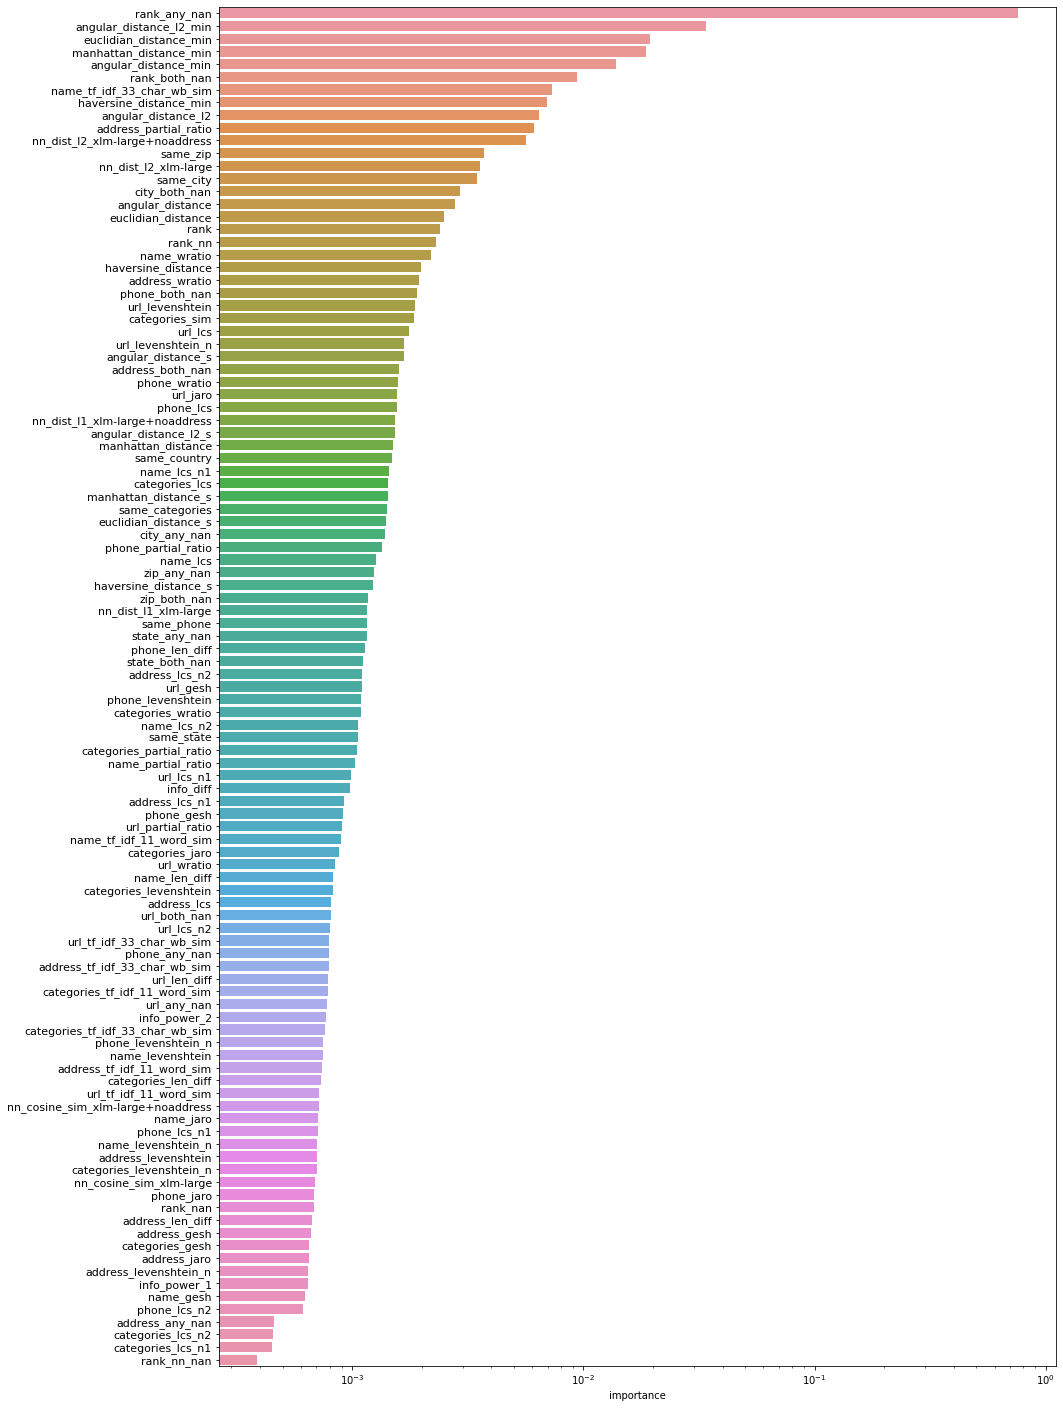

In [43]:
plot_importances(ft_imp)
plt.xscale('log')
plt.show()

### FNs

In [ ]:
# df = prepare_train_data(root=DATA_PATH)

In [ ]:
# for i, id_ in enumerate(preds):
#     if not len(list(missed[i])):
#         continue

#     print('Query')
#     display(df.loc[[id_]])

#     print('Target')
#     display(df.loc[[g for g in gt_matches[id_] if g != id_]])

#     print('Missed')
#     display(df.loc[list(missed[i])])

# #     print('Preds')
# #     display(df.loc[preds_matches[df.index[i]]].head(5))

# #     break
#     print('-' * 50)

#     if i > 1:
#         break

### Post-processing

In [ ]:
from data.post_processing import *

In [ ]:
# preds_pp = limit_numbers(preds, scores, 20)
# print(f"CV IoU : {compute_iou(preds_pp, gt_matches) :.4f}")

In [ ]:
# preds_pp = post_process_matches(preds, mode="remove")
# print(f"CV IoU : {compute_iou(preds_pp, gt_matches) :.4f}")

In [ ]:
preds_pp = post_process_matches(preds, mode="append")
print(f"CV IoU : {compute_iou(preds_pp, gt_matches) :.4f}")

In [ ]:
found_prop, missed = compute_found_prop(preds_pp, gt_matches)

n_matches = sum([len(preds_pp[k]) - 1 for k in preds_pp])

print(f"Found {found_prop * 100 :.2f}% of matches with {numerize(n_matches)} candidates.")